# Iterative solvers

Many methods for discretising PDE operators exist:

- Finite Differences
- Finite Volume Methods
- Finite Element Methods
- Discontinuous Galerkin

So far we have only looked at finite difference methods. One thing they have in common is that they all transform a PDE into a large linear system. For some time-stepping schemes, e.g. explicit Euler, we do not need solve the system. However, in general, we need to be able to quickly solve the resulting linear system.

## Direct Solvers
Let's assume that we have N degrees of freedom (i.e. entries in our vector), then Gaussian elimination will scale with O(N^2). Conversely, a highly optimised sparse direct solvers can reach O(N^3/2). Without taking into account round-off errors, direct methods give an exact solution.

## Iterative Solvers

Iterative solvers consist only of matrix-vector products and generally only give an approximate solution. However, using iterative solvers we can easily achieve a scaling of O(N) when solving the linear system.

There are two major classes of iterative solvers:
1. Stationary iterative solvers, e.g. relaxation methods
2. Krylov subspace methods, e.g. CG, preconditioned CG

In this notebook we will cover some basic relaxation methods. We want to solve a linear system of equations
$Ax=b$                                    
by finding a sequence of approximate solutions $x^{(k)}$ that converge to the true solution $x$.
The error is given by
$$e^{(k)}:=x−x^{(k)}$$

Since the true solution is generally not known, it is not possible to compute the error. We need to introduce a measure for the error that is computable. Let us define the residual:
$$r^{(k)} := b - Ax^{(x)}$$

The residual and the error have a simple relationship:
$$r^{(k)} := b - Ax^{(x)} = Ax - Ax^{(k)} = A(x-x^{(k)})= Ae^{(k)}$$

We can now repose the linear system using the residual:
$$r^{(k)} = Ae^{(k)}$$
This form of the equation is referred to as the residual equation.

From now on we always work with the residual equation $r^{(k)}=Ae^{(k)}$ instead of $Ax^{(k)}=b$.
We approximate the error $e^{(k)}$ in each step. This gives updates $x^{(k+1)} = x^{(k)} + \tilde e^{(k)}$, where $\tilde e^{(k)}$ is an approximation of the error at this step. But how can we compute the approximations $\tilde e^{(k)}$ using the residual equation?

<b>Idea:</b> Solve an easier equation instead.

Let's introduce a matrix $B$, such that 
1. $B$ is easy to invert, e.g. a diagonal matrix
2. $B$ is similar to $A$ in some sense $A\sim B$. We will define what it means to be similar later on. 
Then we can solve the residual equation for $B$
$$B\hat e^{(k)} = r^{(k)}$$
and use $\hat e^{(k)}$ as an approximation to the error $e^{(k)}$ in our original equation. This gives the iterative scheme:
$$x^{(k+1)} = x^{(k)} + \hat e^{(k)}$$

With this simple iterative scheme in mind we now need to figure out how to choose $B$. Let's start with the simplest possible idea and set $B$ to be the diagonal of $A$. The resulting scheme is called Jacobi relaxation. This choice of $B$ is clearly easy to invert. The open question is whether it is sufficiently similar to $A$ to give a reasonable approximation of the error. To get an idea of that let's try it out. We need to implement the following:

### Jacobi Relaxation

For $k=1...$
- Solve $\mathop{diag}(A) \hat e^{(k)} = r^{(k)}$
- Update $x^{(k+1)} = x^{(k)} + \hat e^{(k)}$
- Update residual $r^{(k+1)} = b - Ax^{(k+1)}$

or, more compactly:
$$x^{(k+1)} = x^{(k)} + \mathop{diag}(A)^{-1} r^{(k)} = x^{(k)} + \mathop{diag}(A)^{-1} (b − Ax^{(k)})$$

Since the most computationally expensive operation in an iterative scheme is generally the matrix-vector product, for implementational purposes, we minimise them. This finally gives:
$x^{(k+1)} = \mathop{diag}(A)^{-1} \left(b - (\mathop{diag}(A)-A) x^{(k)}\right)$

Let's set up two different matrices for the solve

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.sparse import diags

N=100
h=1/N
diagonals1 = [-np.ones(N-1), 2*np.ones(N), -np.ones(N-1)]
A1 = diags(diagonals1, [-1, 0, 1]).toarray()/h/h
diagonals2 = [-np.ones(N-1), 2.1*np.ones(N), -np.ones(N-1)]
A2 = diags(diagonals2, [-1, 0, 1]).toarray()/h/h

and a random right hand side

In [2]:
b = 20*np.matlib.rand(N,1)

Solving (with an inbuilt direct) solver

In [4]:
ex1 = np.linalg.solve(A1,b)                                # solve system
Y1 = np.vstack((np.array([[0]]),ex1,np.array([[0]])));      # add Dirichlet boundary
ex2 = np.linalg.solve(A2,b)                                # solve system
Y2 = np.vstack((np.array([[0]]),ex2,np.array([[0]])));      # add Dirichlet boundary

Now we can implement the Jacobi relaxation:

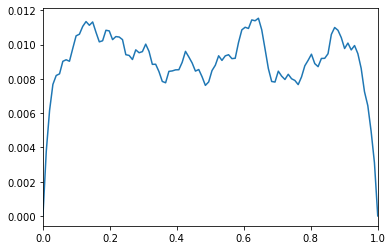

In [11]:
def jacobiRelaxation(A, b, x0, maxIter):
    D = np.diag(np.diag(A))          # Define D_A
    D_inv = np.diag(1 / np.diag(D))  # precompute inverse
    x = x0
    for i in range(maxIter):
        x_new = np.dot(D_inv, b - np.dot(A-D, x)) # Jacobi Relaxation
        if(i == maxIter-1):
            print("Residual", np.linalg.norm(b - np.dot(A,x_new)))
        x = x_new
    return x

x0 = np.zeros(N).reshape(-1,1)    # initial guess
Y = jacobiRelaxation(A2,b,x0,0); #solve
Y = np.vstack((np.array([[0]]),Y,np.array([[0]]))) # add Dirichlet conditions
X = np.linspace(0,1,Y.size)
#plot
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.plot(X, abs(Y-Y2));

### Jacobi Relaxation
In order to implement the Jacobi relaxation we require some additional storage required (x_new). However, x and x_new can be computed in any order (and in parallel).

### Convergence Analysis
To see when the iteration converges let's repose the scheme (yet again):
$$x^{(k+1)} = (I - \mathop{diag}(A)^{-1} A) x^{(k )} + \mathop{diag}(A)^{-1} b =: Mx^{(k )} + Nb$$
- where $I$ is the identity matrix,
- $M:= I - \mathop{diag}(A)^{-1} A$ and $N= \mathop{diag}(A)^{-1}$

Using this formulation we can derive an iterative scheme for the error $e^{(i)} := x - x^{(i)}$:
$$e^{(i+1)} = x - x^{(i+1)} =  x - M x^{(i)} - N b$$

This means that
\begin{align} e^{(i+1)} &= M x + N b - M x^{(i)} - N b  \\ &= M x - M x^{(i)} = M e^{(i)} \\ \Rightarrow  e^{(i)} &= M^i e^{(0)}. \end{align}

Or in other words, the convergence depends on how quickly multiplication with M reduces the error. Now we need a good way of computing that.

Let's assume we know the  eigenvalues $\mu_k$ and eigenvectors $v_k$ of iteration matrix $M$. Then an a multiplication with M reduces to a multiplication with a scalar:
$$M v_k = \mu_k v_k  \quad\Rightarrow \quad M \bigl( \sum_k \alpha_k v_k \bigr) = \sum_k \alpha_k M v_k  = \sum_k \mu_k \alpha_k v_k $$
           
Now we can write the error as a sum of eigenvectors:
$$e^{(0)} = \sum_{k} \alpha_k v_k,$$ 
And compute the effect of $i$ multiplications with $M$:
$$M^i e^{(0)} = M^i \bigl( \sum_k \alpha_k v_k \bigr) =\sum_k (\mu_k)^i \alpha_k v_k $$
                        
Clearly, the scheme can only converge if $\left| \mu_k \right| < 1$ for all $k$. And the closer the eigenvalues $\mu_k$ are to zero, the faster the convergence will be. The overall convergence will dominated by largest eigenvalue $\mu_k$.

For Jacobi relaxation $M:= I - \mathop{diag}(A)^{-1} A$. The eigenvalues of $M$ are less than one if the matrix is strictly diagonally dominant, i.e. if
$$|a_{ii}|>\sum_{i\neq j}|a_{ij}|,~~\forall i.$$

### Gauss-Seidel Relaxation

Following the same general algorithm as Jacobi we can create a somewhat more broadly applicable smoother. We replace the diagonal of A with lower triangular part of A.
So, here: $B = L_A$ (lower triangular part of A)

Directly inverting B is expensive, <em>but</em>, computing y with $By = b$ is cheap. We can simply use forward substitition to compute y
$$y_1 = \frac{b_1}{A_{11}},~ y_2 = \frac{b_2 - A_{21} x_1}{A_{22}},~  \dots , ~
  y_m = \frac{b_m - \sum_{i=1}^{m-1} A_{mi}x_i}{A_{mm}}.$$
  
#### Iteration formulas in matrix-vector notation:
- $ x^{(k+1)} = x^{(k)} + L_A^{-1} r^{(k)}
                   = x^{(k)} + L_A^{-1} \left( b - A x^{(k)} \right)$

#### for implementation:
- $x^{(k+1)} = L_A^{-1} \left( b - ( A - L_A ) x^{(k)} \right)$
- After inserting substition rule: 
    - $x^{(k+1)}_m = A_{mm}^{-1}\left(b_m - \sum_{i=1}^{N}A_{mi}x^{(k)}_i + A_{mm}x^{(k)}_m \right)$

#### for analysis:
- $x^{(k+1)} = \left( I - L_A^{-1}A \right) x^{(k)}  + L_A^{-1} b
                   =: M x^{(k)} + N b$

In [12]:
def gaussSeidelRelaxation(A, b, x0, maxIter):
    x = x0  # initial guess
    res = b - np.dot(A,x)                        # initial residual
    for i in range(maxIter):
        for j in range(0,N):
            x[j] = (1/A[j,j]) * (b[j] - np.dot(A[j,:],x) + A[j,j]*x[j]); # forward substitution and update
        res = b - np.dot(A,x)  
        if(i == maxIter-1):
            print("Residual", np.linalg.norm(res)) 
    return x

Residual 0.005663054194283568


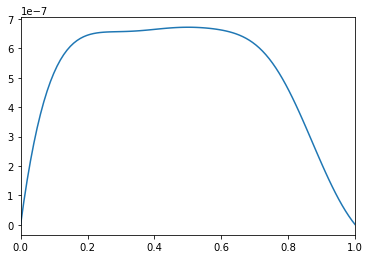

In [15]:
x0 = np.zeros(N).reshape(-1,1)    # initial guess
Y = gaussSeidelRelaxation(A2,b,x0,100);
Y = np.vstack((np.array([[0]]),Y,np.array([[0]])))
X = np.linspace(0,1,Y.size)
#plot
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.plot(X, abs(Y-Y2));

#### Gauss-Seidel Relaxation

In this implementation we do not need an additional vector $x_{new}$ . Instead we compute the solution x in place.

#### Properties
- matrix $A$ needs to be symmetric positive definite (or strictly diagonally dominant)
- usually faster convergence than Jacobi

### Successive-Over-Relaxation (SOR)
We see that the Gauss-Seidel and Jacobi corrections are “too small”. To compensate this we add an over-relaxation-factor $\alpha$ and multiply our correction with it.

For Jacobi Method this gives:
- $x_i^{new} = x_i + \alpha \cdot A_{ii}^{-1}( b_i - \sum_{j=1}^N  A_{ij} x_j)$
- for 2D Poisson model problem (e.g. matrix A1):
    - optimal $\alpha \approx 1.7$ improves convergence: $O(n^2) \to O(n^{3/2})$

Residual 4.973874319339499e-07


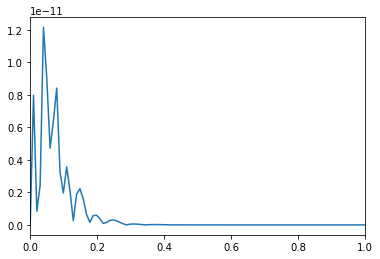

In [17]:
def SOR(A, b, alpha, x0, maxIter):
    x = x0  # initial guess
    xnew = np.zeros(N).reshape(-1,1)
    for i in range(maxIter):
        for j in range(0,N):
            xnew[j] =  x[j] + (alpha/A[j,j]) * (b[j] - np.dot(A[j,:],x));
        if(i == maxIter-1):
            print("Residual", np.linalg.norm( b - np.dot(A,x))) 
        x = xnew
    return x

x0 = np.zeros(N).reshape(-1,1)    # initial guess
Y = SOR(A2,b,1.7,x0,100);
Y = np.vstack((np.array([[0]]),Y,np.array([[0]])))
X = np.linspace(0,1,Y.size)
#plot
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.plot(X, abs(Y-Y2));

### Relaxation Methods: Summary

How about performance? For the methods we have looked at so far it is usually quite slow. In the code example with size  only $N=100$: 
    1. Jacobi:needed 140 of iterations to reach tol=$1e-4$
    2. Gauss-Seidel: needed $70$ iterations tol=$1e-4$
    3. SOR: needed $36$ iterations tol=$1e-4$
        
#### Our next topics:
1. How slow are the methods exactly?
2. What is the underlying reason?
3. Is there a fix?